In [1]:
import pandas as pd
import numpy as np
from fastai.vision.all import *
from fastai.vision.widgets import *

In [2]:
Train = pd.read_csv('/home/unicconaiadmin/Music1/Msa/Train (27).csv')
Test = pd.read_csv('/home/unicconaiadmin/Music1/Msa/Test (30).csv')

In [3]:
damage = Train.damage.unique()

In [4]:
import os

missing_images = []

def get_x_fn(o):
    img_path = f"images/{o['filename']}"
    if os.path.exists(img_path):
        return img_path
    else:
        missing_images.append(o['filename'])
        return None

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab=damage)),
                   get_x=get_x_fn,
                   get_y=ColReader('damage'),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(320, method='squish'),
                   batch_tfms=aug_transforms(size=128, min_scale=0.75)
                   )


In [5]:
dls = dblock.dataloaders(Train)

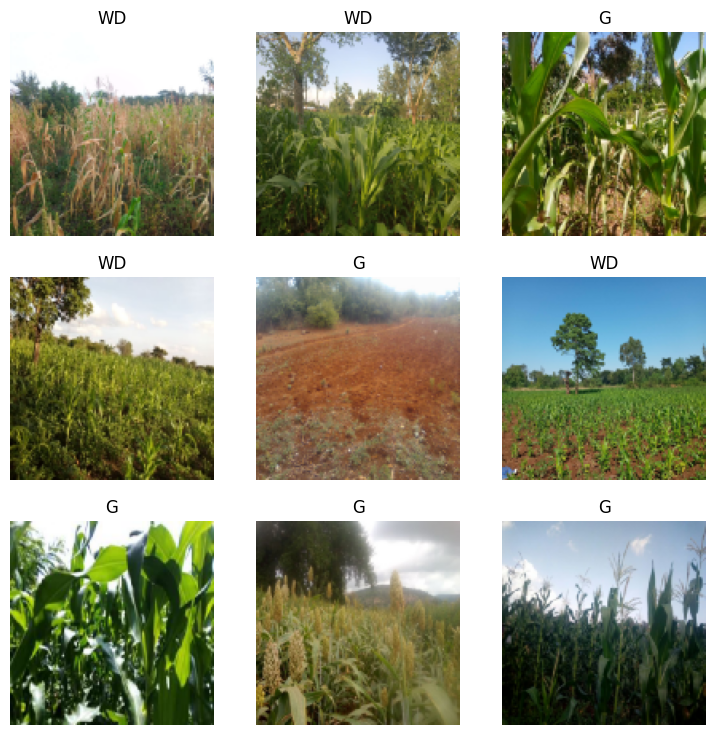

In [6]:
dls.valid.show_batch()

In [ ]:
cls = dblock.new(item_tfms=RandomResizedCrop(128, min_scale=0.2))
dls = dblock.dataloaders(Train)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
dblock = dblock.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.6),
    batch_tfms=[
        *aug_transforms(mult=2),
        Rotate(max_deg=20),
        Flip(),
        Brightness(max_lighting=0.6),
        Contrast(max_lighting=0.6),
        Zoom(max_zoom=1.1),
        Warp(),
        Dihedral(),
        RandomErasing(p=0.2),
        CropPad(size=128),
        RandomResizedCrop(128),
    ]
)

dls = dblock.dataloaders(Train)
dls.train.show_batch(max_n=8, nrows=1, unique=True)


In [7]:
model = vision_learner(dls, 'convnext_large_in22k', loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

/home/unicconaiadmin/.local/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_large_in22k to current convnext_large.fb_in22k.
  model = create_fn(


In [ ]:
model.lr_find(suggest_funcs=(valley,slide))

In [8]:
model.fine_tune(10, 0.01)

epoch,train_loss,valid_loss,accuracy,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 23.69 GiB total capacity; 1.71 GiB already allocated; 74.94 MiB free; 1.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(6, nrows=3)

In [ ]:
import os
test_dl = model.dls.test_dl(Test['filename'].tolist())
def get_x_fn(o):
    img_path = f"images/{o['filename']}"
    if os.path.exists(img_path):
        return img_path
    else:
        return "path_to_default_image.jpg"

Test['image_path'] = Test.apply(get_x_fn, axis=1)
test_dl_default = model.dls.test_dl(Test['image_path'].tolist())
preds, _ = model.get_preds(dl=test_dl_default)
preds1, _ = model.tta(dl=test_dl_default)
preds2, _ = model.predict(dl=test_dl_default)
en_pred = (preds + preds1 + preds2) /3
preds = F.softmax(preds, dim=1)
class_labels = model.dls.vocab
predicted_labels = [class_labels[idx] for idx in torch.argmax(preds, dim=1)]

Test['predicted_label'] = predicted_labels
Test['confidence'] = preds.max(dim=1).values.tolist()
print(Test[['filename', 'predicted_label', 'confidence']])


In [ ]:
preds

In [ ]:
damage, model.dls.vocab

In [ ]:
submission_sf = pd.DataFrame({

    'ID': Test['ID'],
    'DR': preds[:, 0].squeeze().numpy(),
    'G' : preds[:, 1].squeeze().numpy(),
    'ND': preds[:, 2].squeeze().numpy(),
    'WD': preds[:, 3].squeeze().numpy(),
    'other': preds[:, 4].squeeze().numpy(),
})

In [ ]:
submission_sf.to_csv("Sub_1.csv",index=False)

In [ ]:
model_path = '/home/unicconaiadmin/Templates/Msa/model_save.pt'

In [ ]:
model.save(model_path)

In [ ]:
loaded_model = load_learner(model_path)

loaded_encoder = cnn_learner(dls, resnet34)
loaded_encoder = loaded_encoder.load_encoder(model_path)


In [ ]:
preds, targets = loaded_model.get_preds(dl=test_dl)
with torch.no_grad():
    new_features = loaded_encoder.model[0](test_dl.one_batch()[0])